<a href="https://colab.research.google.com/github/djfLtC0dr/python-playground/blob/main/DASC522/djfDASC522hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sqlite3 Database & Helper Classes

In [123]:
import sqlparse
from sqlparse.sql import IdentifierList, Identifier,  Function
from sqlparse.tokens import Keyword, DML
from collections import namedtuple
import itertools
import sqlite3
import os
import pandas as pd
from typing import List

class Reference(namedtuple('Reference', ['schema', 'name', 'alias', 'is_function'])):
    __slots__ = ()

    def has_alias(self):
        return self.alias is not None

    @property
    def is_query_alias(self):
        return self.name is None and self.alias is not None

    @property
    def is_table_alias(self):
        return self.name is not None and self.alias is not None and not self.is_function

    @property
    def full_name(self):
        if self.schema is None:
            return self.name
        else:
            return self.schema + '.' + self.name

def _is_subselect(parsed):
    if not parsed.is_group:
        return False
    for item in parsed.tokens:
        if item.ttype is DML and item.value.upper() in ('SELECT', 'INSERT',
                                                        'UPDATE', 'CREATE', 'DELETE'):
            return True
    return False


def _identifier_is_function(identifier):
    return any(isinstance(t, Function) for t in identifier.tokens)


def _extract_from_part(parsed):
    tbl_prefix_seen = False
    for item in parsed.tokens:
        if item.is_group:
            for x in _extract_from_part(item):
                yield x
        if tbl_prefix_seen:
            if _is_subselect(item):
                for x in _extract_from_part(item):
                    yield x
            # An incomplete nested select won't be recognized correctly as a
            # sub-select. eg: 'SELECT * FROM (SELECT id FROM user'. This causes
            # the second FROM to trigger this elif condition resulting in a
            # StopIteration. So we need to ignore the keyword if the keyword
            # FROM.
            # Also 'SELECT * FROM abc JOIN def' will trigger this elif
            # condition. So we need to ignore the keyword JOIN and its variants
            # INNER JOIN, FULL OUTER JOIN, etc.
            elif item.ttype is Keyword and (
                    not item.value.upper() == 'FROM') and (
                    not item.value.upper().endswith('JOIN')):
                tbl_prefix_seen = False
            else:
                yield item
        elif item.ttype is Keyword or item.ttype is Keyword.DML:
            item_val = item.value.upper()
            if (item_val in ('COPY', 'FROM', 'INTO', 'UPDATE', 'TABLE') or
                    item_val.endswith('JOIN')):
                tbl_prefix_seen = True
        # 'SELECT a, FROM abc' will detect FROM as part of the column list.
        # So this check here is necessary.
        elif isinstance(item, IdentifierList):
            for identifier in item.get_identifiers():
                if (identifier.ttype is Keyword and
                        identifier.value.upper() == 'FROM'):
                    tbl_prefix_seen = True
                    break

def _extract_table_identifiers(token_stream):
    for item in token_stream:
        if isinstance(item, IdentifierList):
            for ident in item.get_identifiers():
                try:
                    alias = ident.get_alias()
                    schema_name = ident.get_parent_name()
                    real_name = ident.get_real_name()
                except AttributeError:
                    continue
                if real_name:
                    yield Reference(schema_name, real_name,
                                    alias, _identifier_is_function(ident))
        elif isinstance(item, Identifier):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))
        elif isinstance(item, Function):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))

def extract_tables(sql):
    # let's handle multiple statements in one sql string
    extracted_tables = []
    statements = list(sqlparse.parse(sql))
    for statement in statements:
        stream = _extract_from_part(statement)
        extracted_tables.append([ref.name for ref in _extract_table_identifiers(stream)])
    return list(itertools.chain(*extracted_tables))

class CSVDriver:
    def __init__(self, table_dir_path: str):
        self.table_dir_path = table_dir_path  # where tables (ie. csv files) are located
        self._con = None

    @property
    def con(self) -> sqlite3.Connection:
        """Make a singleton connection to an in-memory SQLite database"""
        if not self._con:
            self._con = sqlite3.connect(":memory:")
        return self._con
    
    def _exists(self, table: str) -> bool:
        query = """
        SELECT name
        FROM sqlite_master 
        WHERE type ='table'
        AND name NOT LIKE 'sqlite_%';
        """
        tables = self.con.execute(query).fetchall()
        return table in tables

    def _load_table_to_mem(self, table: str, sep: str = None) -> None:
        """
        Load a CSV into an in-memory SQLite database
        sep is set to None in order to force pandas to auto-detect the delimiter
        """
        if self._exists(table):
            return
        file_name = table + ".csv"
        path = os.path.join(self.table_dir_path, file_name)
        if not os.path.exists(path):
            raise ValueError(f"CSV table {table} does not exist in {self.table_dir_path}")
        df = pd.read_csv(path, sep=sep, engine="python")  # set engine to python to skip pandas' warning
        df.to_sql(table, self.con, if_exists='replace', index=False, chunksize=10000)

    def query(self, query: str) -> List[tuple]:
        """
        Run an SQL query on CSV file(s). 
        Tables are loaded from table_dir_path
        """
        tables = extract_tables(query)
        for table in tables:
            self._load_table_to_mem(table)
        cursor = self.con.cursor()
        cursor.execute(query)
        records = cursor.fetchall()
        return records

Data Prep => Need to get Dates & Timestamps in same format

In [124]:
import csv
from datetime import datetime

sleep = 'sleep'
ready = 'readiness'
workout = 'workout'
mdy_format = '%m/%d/%Y'
input_files = [sleep, ready, workout] 

def parse_date(input_file):
  """
  Output csv to formatted dates to 
  faciliate SQL Join
  """
  with open(f"/{input_file}.csv", 'r') as infile, open(f"/t_{input_file}.csv", 'w') as outfile:
    reader = csv.reader(infile)
    headers = next(reader, None)  # returns the headers or `None` if the input is empty
    writer = csv.writer(outfile)
    if headers:
      writer.writerow(headers) # write the header line
    if input_file == sleep:
      for row in reader:
        dt = datetime.fromisoformat(row[1].replace('Z', '+00:00')) #parse the datetime 
        row[1] = dt.strftime(mdy_format)           #assign the revised format
        writer.writerow(row)  
    elif input_file == ready:
      for row in reader:      
        dt = datetime.strptime(row[0], '%Y-%m-%d')    #parse the datetime
        row[0] = dt.strftime(mdy_format)     #assign the revised format
        writer.writerow(row) 
    else: # workout
      for row in reader:    
        writer.writerow(row) # workout date is in mdy_format
  return     

for input_file in input_files:
    parse_date(input_file)
 



Load tables from database into Pandas dataframe object

In [125]:
db_path = r"/"
driver = CSVDriver(db_path)
sel_query = """
SELECT S.overall_score, S.composition_score, S.revitalization_score, S.duration_score, S.deep_sleep_in_minutes, S.restlessness,
   R.readiness_score_value,R.srl_normalized_score,R.ff_normalized_score,R.hrv_normalized_score,  
   W.notes AS rpe
FROM t_sleep S
LEFT JOIN t_readiness R
ON S.timestamp= R.date
LEFT JOIN t_workout W
ON R.date = W.date;
"""
data = pd.DataFrame.from_records(driver.query(sel_query))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       517 non-null    int64  
 1   1       517 non-null    int64  
 2   2       517 non-null    int64  
 3   3       517 non-null    int64  
 4   4       517 non-null    int64  
 5   5       517 non-null    float64
 6   6       450 non-null    float64
 7   7       450 non-null    float64
 8   8       450 non-null    float64
 9   9       450 non-null    float64
 10  10      379 non-null    object 
dtypes: float64(5), int64(5), object(1)
memory usage: 44.6+ KB
None


Data Prep => we need to subset data by mask where @RPE exists

In [126]:
mask = data[10].str.contains('@RPE', case=False, na=False)
data = data[mask]
# print(data.info())
# Extract all instances of RPE as int from notes = index 10
data[10] = data[10].str.extract(r'(@RPE+\d+)')
data[10] = data[10].str[4:].astype(int)
dict_col_names = {
    0: 'sleep_score',
    1: 'composite_score',
    2: 'revitalization_score',
    3: 'duration_score',
    4: 'deep_sleep_mins',
    5: 'restlessness',
    6: 'readiness_score',
    7: 'sleep_reservoir_lvl',
    8: 'fitness_fatigue',
    9: 'heart_rt_var',
    10: 'rpe'
}
data.rename(dict_col_names, axis=1, inplace=True)
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 59 to 505
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sleep_score           115 non-null    int64  
 1   composite_score       115 non-null    int64  
 2   revitalization_score  115 non-null    int64  
 3   duration_score        115 non-null    int64  
 4   deep_sleep_mins       115 non-null    int64  
 5   restlessness          115 non-null    float64
 6   readiness_score       115 non-null    float64
 7   sleep_reservoir_lvl   115 non-null    float64
 8   fitness_fatigue       115 non-null    float64
 9   heart_rt_var          115 non-null    float64
 10  rpe                   115 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 10.8 KB
None


,sleep_score,composite_score,revitalization_score,duration_score,deep_sleep_mins,restlessness,readiness_score,sleep_reservoir_lvl,fitness_fatigue,heart_rt_var,rpe
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,81.860870,20.191304,19.226087,42.443478,69.086957,0.070932,66.573913,87.295652,67.530435,49.321739,5.904348
std,4.426568,1.577782,2.622644,2.464454,18.798827,0.015129,25.304830,11.176396,24.727753,9.746387,4.879197
min,67.000000,15.000000,14.000000,35.000000,27.000000,0.043157,7.000000,23.000000,7.000000,26.000000,1.000000
25%,79.500000,19.000000,17.000000,41.000000,58.000000,0.061139,50.000000,85.000000,54.500000,42.000000,3.000000
50%,82.000000,21.000000,20.000000,43.000000,66.000000,0.067358,69.000000,90.000000,72.000000,49.000000,5.000000
75%,85.000000,21.000000,21.000000,43.000000,82.000000,0.076072,88.000000,93.000000,88.000000,56.000000,8.000000
max,90.000000,23.000000,24.000000,47.000000,121.000000,0.116041,100.000000,99.000000,100.000000,82.000000,51.000000


Data clean-up => fix outlier(s), DU, Split

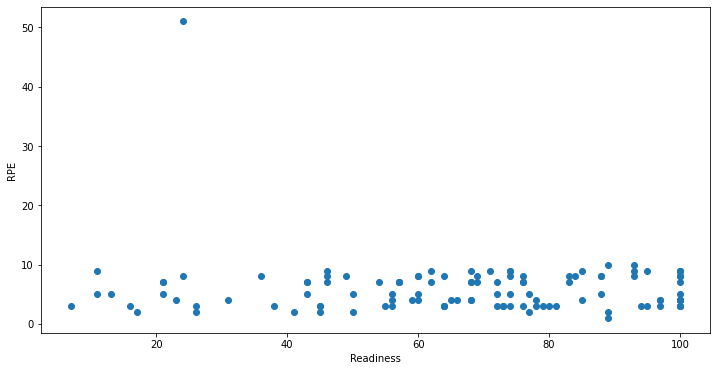

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(data['readiness_score'], data['rpe'])
ax.set_xlabel('Readiness')
ax.set_ylabel('RPE')
plt.show()

# Z score
from scipy import stats
import numpy as np
 
z = np.abs(stats.zscore(data['rpe']))
threshold = 3

# Position of the outlier
idx_outlier = np.where(z > threshold)
# print(data.iloc[idx_outlier])

median_rpe = data['rpe'].quantile(0.50)
outlier_rpe = data['rpe'].quantile(0.9915)
# print(outlier_rpe)
# Any thing over 10 needs to be replaced with the median rpe
data['rpe'] = np.where(data['rpe'] > outlier_rpe, int(median_rpe), data['rpe'])

In [130]:
print(data.describe())

# Split the data X, y
# separate the independent and dependent variables
X = data.loc[:, data.columns != 'rpe']
y = data.loc[:, data.columns == 'rpe']

       sleep_score  composite_score  revitalization_score  duration_score  \
count   115.000000       115.000000            115.000000      115.000000   
mean     81.860870        20.191304             19.226087       42.443478   
std       4.426568         1.577782              2.622644        2.464454   
min      67.000000        15.000000             14.000000       35.000000   
25%      79.500000        19.000000             17.000000       41.000000   
50%      82.000000        21.000000             20.000000       43.000000   
75%      85.000000        21.000000             21.000000       43.000000   
max      90.000000        23.000000             24.000000       47.000000   

       deep_sleep_mins  restlessness  readiness_score  sleep_reservoir_lvl  \
count       115.000000    115.000000       115.000000           115.000000   
mean         69.086957      0.070932        66.573913            87.295652   
std          18.798827      0.015129        25.304830            11.1763